In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from random import randint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.base import clone
from scipy.spatial.distance import cdist
from itertools import combinations
from sklearn.metrics import calinski_harabasz_score

In [15]:
class DataGenerator:
    def __init__(self):
        pass
        
    """
    Parameters
    ----------
    n_samples : int or array-like, optional (default=100)
        If int, it is the total number of points equally divided among
        clusters.
        If array-like, each element of the sequence indicates
        the number of samples per cluster.
    n_features : int, optional (default=3)
        The number of features for each sample.
    centers : int or array of shape [n_centers, n_features], optional
        (default=None)
        The number of centers to generate, or the fixed center locations.
        If n_samples is an int and centers is None, 3 centers are generated.
        If n_samples is array-like, centers must be
        either None or an array of length equal to the length of n_samples.
    cluster_std : float or sequence of floats, optional (default=1.0)
        The standard deviation of the clusters.
    random_state : int, or None (default)
        Determines random number generation for dataset creation

    """        
    def generate(self,n_samples=100,n_features=3,cluster_std=0.5, minimum_distance=4,centers=None,random_state=None):

        do_loop=True
        attempt=0
        
        while do_loop:
            attempt=attempt+1
        
            data= make_blobs(
                random_state=random_state,
                n_samples=n_samples, 
                centers=centers, 
                n_features=n_features,
                cluster_std=cluster_std)
            
            num_centers = len(centers) if isinstance(centers, list) else centers
            
            kmeans = KMeans(n_clusters=num_centers).fit(data[0])
            #print("cluster_centers:",kmeans.cluster_centers_)
            distances = cdist(kmeans.cluster_centers_,kmeans.cluster_centers_)
            distances = distances[np.triu_indices(num_centers,k=1)] #get only the distances above the diagonal
            #print("distances:",distances)
            
            do_loop = np.min(distances)<minimum_distance
            if (do_loop and attempt>10):
                print("minimum distance condition wasn't met within 10 attempts. abort.")
                do_loop=False
                
        
        return data

    def add_noise(self,X,noise_channels_to_add,noise_level=1):
        
        noise_channels = np.zeros((len(X),noise_channels_to_add))
        X= np.hstack((X,noise_channels))
        
        noise = np.random.uniform(
                low=noise_level*np.max(X), 
                high=noise_level*np.min(X),
                size=X.shape)
        X= X+noise
        return X
    
    def draw_data(self, X, y):
        df = pd.DataFrame(X)
        lst_vars=list(combinations(df.columns,2))
        #print(lst_vars)
        plt.figure(figsize=(15,15))
        plt.suptitle('Pairwise distribution of features')
        for i in range(1,len(lst_vars)+1):
            plt.subplot(5,5,i)
            dim1=lst_vars[i-1][0]
            dim2=lst_vars[i-1][1]
            plt.scatter(df[dim1],df[dim2],c=y,edgecolor='k',s=150)
            plt.xlabel(f"{dim1}",fontsize=10)
            plt.ylabel(f"{dim2}",fontsize=10)
        plt.figure(figsize=(10,10))
        plt.suptitle('Class distribution by feature')
        for i,c in enumerate(df.columns):
            plt.subplot(3,2,i+1)
            sns.boxplot(y=df[c],x=y)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.xlabel("Class",fontsize=10)
            plt.ylabel(c,fontsize=10)

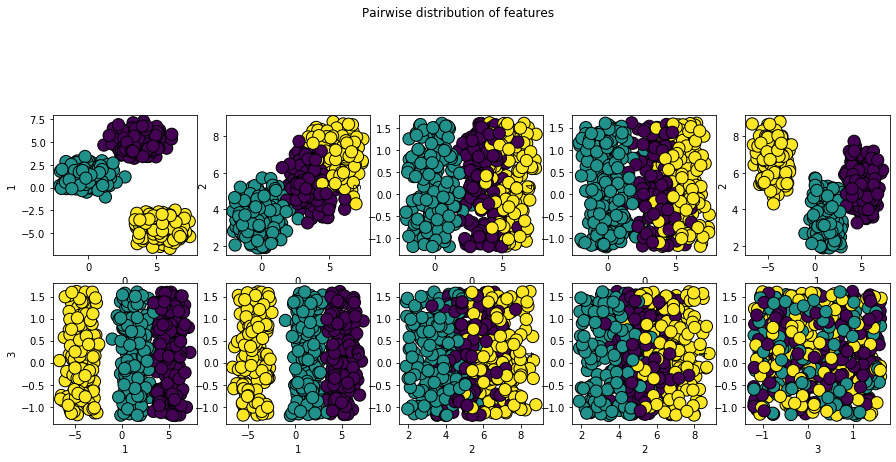

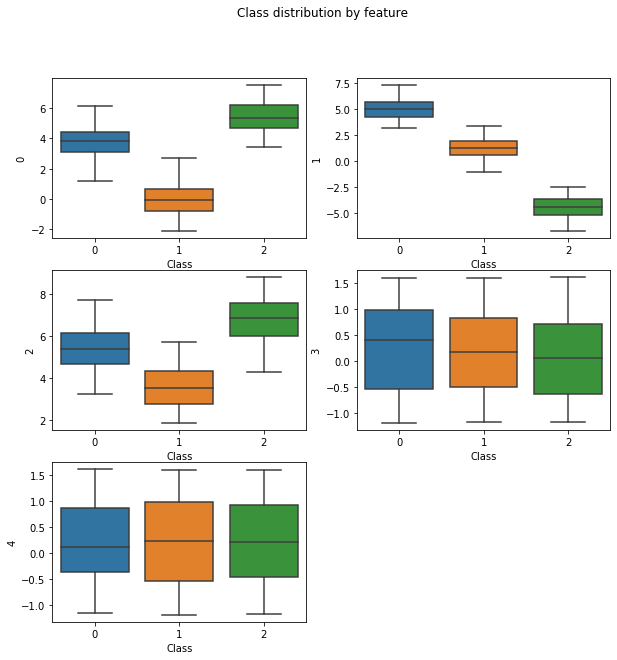

In [16]:
# Generate data and plot
DataGen = DataGenerator()
data=DataGen.generate(n_samples=500,n_features=3,cluster_std=0.5,minimum_distance=3,centers=3)
noisy_data = DataGen.add_noise(data[0],2,0.2)
DataGen.draw_data(noisy_data,data[1])

In [19]:
class ClusterFinder:

    def __init__(self, pipe):
        self.pipe = pipe
        self.model_score=0
        self.k_val=0
        
    """
    https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    """
    #BIC
    def optimal_k_bic(self,X,num_iterations=20):

        K = range(1,10)
        bic = np.zeros((len(K),num_iterations))
        for k in K:
            for i in range(num_iterations):
                self.pipe['model'].n_components=k
                X_pca = self.transform(X)
                self.pipe['model'].fit(X_pca)
                bic[k-1,i] = self.pipe['model'].bic(X_pca)
        
        bic=np.mean(bic,axis=1)
        #plt.figure()
        #plt.plot(K,bic) 
        
        # find elbow: first +1 because k values are 1..10, not 0..9. second +1 is because we round up
        self.k_val = np.argmax(np.roll(bic,1)-bic)+1+1   

        return self.k_val
    
    
    def optimal_k_silhouette(self,X,num_iterations=20):
    
        """Since we already know that the fitting procedure is not deterministic, we run the fit several times for each number of clusters"""
        """ silhouette seems to be very bad in presence of noise"""
        K = range(2,10)
        silhouette = np.zeros((len(K),num_iterations))
        for k in K:
            for i in range(num_iterations):
                self.pipe['model'].n_components=k
                X_pca = self.transform(X)
                gmm = self.pipe['model']
                gmm.fit(X_pca)        
                silhouette[k-2,i] = silhouette_score(X_pca, gmm.predict(X_pca))
        
        """best five values, then average"""        
        silhouette=np.sort(silhouette,axis=1)[:,-5:]
        silhouette=np.mean(silhouette,axis=1)
        plt.figure()
        plt.plot(K,silhouette)
    
        self.k_val = np.argmax(silhouette)+2 #because K starts from 2.
        return self.k_val 

    def fit(self, X,y=[]):
        if len(y)==0:
            self.pipe.fit(X)
        else:
            self.pipe.fit(X,y)
        
    def supervised_fit(self, X, y,num_iter=10,n_components=None):
        accuracy=[]
        best_score=0

        k_to_use = n_components if n_components!=None else self.optimal_k_bic(X)        
        self.pipe['model'].n_components = k_to_use

        for i in range(num_iter):
            rand = randint(0, 1000)
            self.pipe['model'].random_state = rand
            self.pipe.fit(X,y)
            y_pred = self.pipe.predict(X)
            score = clustered_label_accuracy_score(y,y_pred)['accuracy']
            print("iteration {}, ,rand {}, score:{:1.2f}".format(i,rand,score))
            accuracy.append(score)
            if score>best_score:
                best_params = self.pipe.get_params()
        self.model_score = np.mean(accuracy)
        self.pipe.set_params(**best_params)
        self.pipe.fit(X,y)

    def transform(self, X):
        self.pipe['scalar'].fit(X)
        return self.pipe.named_steps.pca.fit_transform(self.pipe.named_steps.scalar.transform(X))

    def inverse_transform(self, X):
        X_pca = self.pipe.named_steps.pca.inverse_transform(X)
        return self.pipe.named_steps.scalar.inverse_transform(X_pca)
    
    def predict(self, X):
        return self.pipe.predict(X)
    
    def score_kh(self,X,y_pred):
        return calinski_harabasz_score(X,y_pred)
    
    def score_sil(self,X,y_pred):
        return silhouette_score(X,y_pred)
    
    def bic(self,X):
        self.pipe.named_steps.model.bic(self.transform(X))
        
    def accuracy_score(self):
        return self.model_score
    
    # model clusttering fit score based on sum square distance between cluster center and points in the cluster. 
    # X here is the original X. pre-transform
    def score(self,X,y_pred):
        centers = self.inverse_transform(self.pipe.named_steps.model.means_)
        centers = [ centers[i] for i in y_pred ]
        centers = np.array(centers)
        return np.sum((X-centers)**2)/len(X)

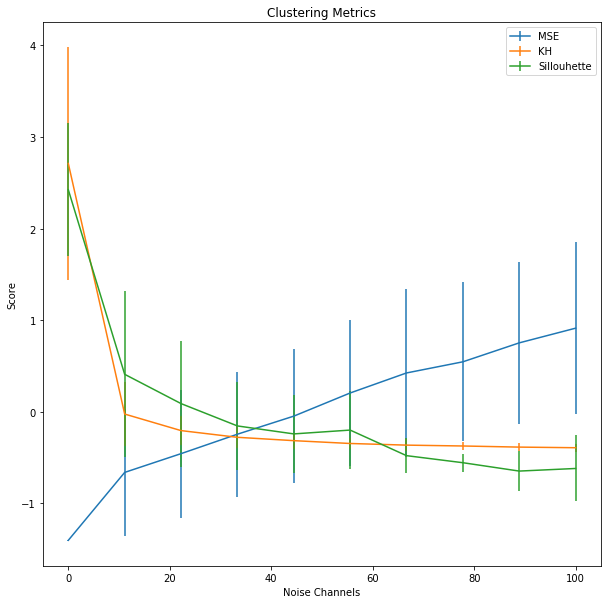

In [30]:
#Test 1: Compare different metrics for clusterization
num_k = 3
iterations = 10
noise_level = 0.1
noise_channels_2chk = np.linspace(0,100,num=10)
res = []

pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('model',GaussianMixture(n_components=3,covariance_type='full',random_state=None))
])

model = ClusterFinder(pipe)
model.pipe.named_steps.model.n_components=3

for i in np.arange(0,iterations):
    X_orig, y = DataGen.generate(n_samples=500, n_features=3, minimum_distance=1,centers=num_k,cluster_std=0.5)
    for noise_channels in noise_channels_2chk:
        X_noisy = DataGen.add_noise(X_orig, noise_channels_to_add=noise_channels.astype(int), noise_level=noise_level)
        rand = randint(0, 1000)
        model.pipe.named_steps.model.random_state = rand
        model.fit(X_noisy,y)
        y_pred = model.pipe.predict(X_noisy)
        MSE = model.score(X_noisy,y_pred)
        KH = model.score_kh(X_noisy,y_pred)
        Sil = model.score_sil(X_noisy,y_pred)
        res.append(np.array([noise_channels,MSE,KH,Sil]))
        
df = pd.DataFrame(list(map(np.ravel, res)),columns=['noise_channels', 'MSE', 'KH', 'Sillouhette'])
df.KH = (df.KH - df.KH.mean()) / df.KH.std()
df.MSE = (df.MSE - df.MSE.mean()) / df.MSE.std()
df.Sillouhette = (df.Sillouhette - df.Sillouhette.mean()) / df.Sillouhette.std()
fig= plt.figure(figsize=(10,10))

for metric in ('MSE','KH','Sillouhette'):
    group = df.groupby('noise_channels')
    means = group.mean() 
    stds = group.std()
    plt.errorbar(list(means.index),list(means[metric]),list(stds[metric]),label=metric)
    
plt.ylabel("Score")
plt.xlabel("Noise Channels")
plt.title("Clustering Metrics")
plt.legend(loc='upper right')


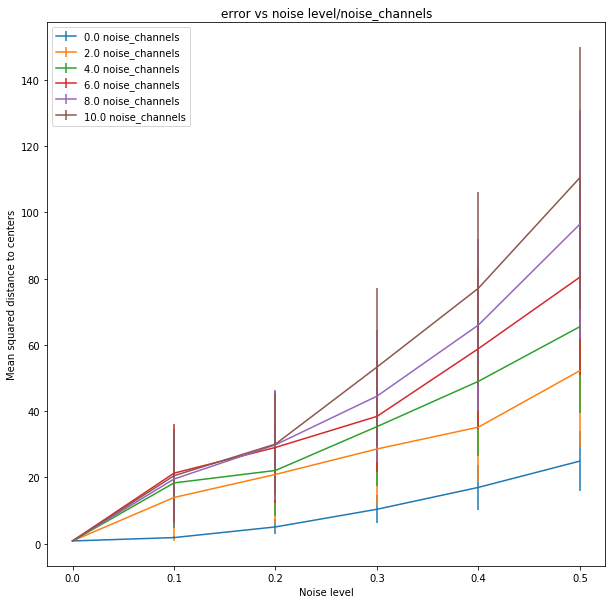

In [17]:
# Test 1: Effect of adding noise channels on constant K centers
num_k = 3
iterations = 10
noise_level_2check = np.around(np.linspace(0,0.5,num=6), decimals=1)
noise_channels_2check = np.linspace(0,10,num=6)
res=[]

pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('model',GaussianMixture(n_components=3,covariance_type='full',random_state=None))
])

model = ClusterFinder(pipe)
model.pipe.named_steps.model.n_components=3

for i in np.arange(0,iterations):
    X_orig, y = DataGen.generate(n_samples=500,n_features=3, minimum_distance=1,centers=num_k,cluster_std=0.5)

    for noise_level in noise_level_2check:
        for noise_channels in noise_channels_2check:
            noise_level_real = noise_level#+0.002*noise_channels
            X_noisy = DataGen.add_noise(X_orig, noise_channels_to_add=noise_channels.astype(int), noise_level=noise_level_real)
            rand = randint(0, 1000)
            model.pipe.named_steps.model.random_state = rand
            model.fit(X_noisy,y)
            y_pred = model.pipe.predict(X_noisy)
            score = model.score(X_noisy,y_pred)
            res.append(np.array([noise_level_real,noise_channels,score]))
        
            
df = pd.DataFrame(list(map(np.ravel, res)),columns=['noise_level', 'noise_channels', 'score'])
fig= plt.figure(figsize=(10,10))

for noise_channels in noise_channels_2check:
    group = df[df.noise_channels==noise_channels].groupby(['noise_level'])
    means = group.mean()
    stds = group.std()
    plt.errorbar(list(means.index),list(means.score),list(stds.score),label=str(noise_channels)+' noise_channels')
    
plt.ylabel("Mean squared distance to centers")
plt.xlabel("Noise level")
plt.title("error vs noise level/noise_channels")
plt.legend(loc='upper left')


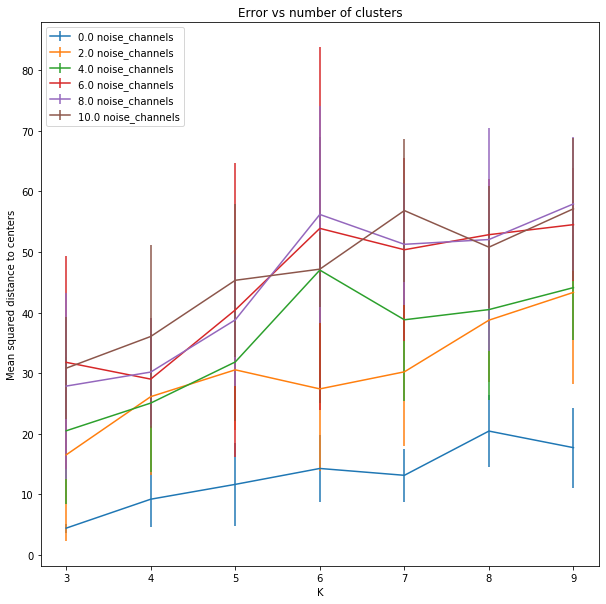

In [32]:
# Test 2: Effect of increasing K with constant noise level
num_k = np.arange(3,10)
iterations = 10
noise_level = 0.2
noise_channels_2chk = np.linspace(0,10,num=6)
res=[]

model.pipe.named_steps.model.n_components=3

for i in np.arange(0,iterations):

    for k in num_k:
        for noise_channels in noise_channels_2chk:
            X_orig, y = DataGen.generate(n_samples=500,n_features=3, minimum_distance=1,centers=k,cluster_std=0.5)
            noise_level_real = noise_level#+0.002*noise_channels
            X_noisy = DataGen.add_noise(X_orig, noise_channels_to_add=noise_channels.astype(int), noise_level=noise_level_real)
            rand = randint(0, 1000)
            model.pipe.named_steps.model.random_state = rand
            model.pipe.named_steps.model.n_components = k
            model.fit(X_noisy,y)
            y_pred = model.pipe.predict(X_noisy)
            score = model.score(X_noisy,y_pred)
            res.append(np.array([k,noise_channels,score]))
        
            
df = pd.DataFrame(list(map(np.ravel, res)),columns=['k','noise_channels','score'])
fig= plt.figure(figsize=(10,10))

for noise_channels in noise_channels_2chk:
    group = df[df.noise_channels==noise_channels].groupby(['k'])
    means = group.mean()
    stds = group.std()
    plt.errorbar(list(means.index),list(means.score),list(stds.score),label=str(noise_channels)+' noise_channels')
    
plt.ylabel("Mean squared distance to centers")
plt.xlabel("K")
plt.title("Error vs number of clusters")
plt.legend(loc='upper left')